### Project

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import networkx as nx

In [2]:
df=pd.read_csv('../ADS_project/nacti_metadata.csv/nacti_metadata.csv')
df.head()

C:\Users\kyles\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3,4,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,seq_no,id,filename,study,location,width,height,category_id,name,genus,family,order,class,common_name
0,0,2010_Unit150_Ivan097_img0001.jpg,part0/sub000/2010_Unit150_Ivan097_img0001.jpg,CPW,"San Juan Mntns, Colorado",2048,1536,10,cervus elaphus,cervus,cervidae,artiodactyla,mammalia,red deer
1,1,2010_Unit150_Ivan097_img0002.jpg,part0/sub000/2010_Unit150_Ivan097_img0002.jpg,CPW,"San Juan Mntns, Colorado",2048,1536,10,cervus elaphus,cervus,cervidae,artiodactyla,mammalia,red deer
2,2,2010_Unit150_Ivan097_img0003.jpg,part0/sub000/2010_Unit150_Ivan097_img0003.jpg,CPW,"San Juan Mntns, Colorado",2048,1536,10,cervus elaphus,cervus,cervidae,artiodactyla,mammalia,red deer
3,3,2010_Unit150_Ivan097_img0004.jpg,part0/sub000/2010_Unit150_Ivan097_img0004.jpg,CPW,"San Juan Mntns, Colorado",2048,1536,10,cervus elaphus,cervus,cervidae,artiodactyla,mammalia,red deer
4,4,2010_Unit150_Ivan097_img0005.jpg,part0/sub000/2010_Unit150_Ivan097_img0005.jpg,CPW,"San Juan Mntns, Colorado",2048,1536,10,cervus elaphus,cervus,cervidae,artiodactyla,mammalia,red deer


In [3]:
print('Number of objects:',len(df))

Number of objects: 3382215


In [4]:
print(len(df.common_name.unique()))

50


The dataset consists of metadata for wildlife camera trap images. It has 3382215 objects and 14 attributes. The useful elements of the data consist of the id for the image (which contains the camera trap that took the image), the location of the camera trap, and the name of the species. The locations consist of California, Colorado, and Florida.

# Preproccessing

Need to eleminate rows where the camera trap did not pick up anything (i.e. where df['common_name'] = empty)

In [5]:
df.drop(df.index[df['common_name'] == 'empty'], inplace=True) #eliminate empty rows
df.drop(df.index[df['common_name'] == 'vehicle'], inplace=True) #eliminate rows with vehicles
df.drop(df.index[df['common_name'] == 'domestic dog'], inplace=True) #eliminate rows with domesticated dogs
df.drop(df.index[df['common_name'] == 'domestic cow'], inplace=True) #eliminate rows with domesticated cow
df.drop(df.index[df['common_name'] == 'horse'], inplace=True) #eliminate rows with horse
df.drop(df.index[df['common_name'] == 'donkey'], inplace=True) #eliminate rows with donkeys
print('Number of objects after removing empty rows',len(df))

Number of objects after removing empty rows 863813


For Colorado, need to eleminate the .jpg tag in order to get unique camera trap id's. For California and Florida, I need the substring of the camera trap id's that only contains the characters up to the first underscore.

In [6]:
camera_traps = []

for index, row in df.iterrows():
    if row['location'] == 'San Juan Mntns, Colorado':
        camera_traps.append(row['id'][0:row['id'].rfind('_')])
    else:
        camera_traps.append(row['id'][0:row['id'].index('_')])

df['camera_traps'] = camera_traps

In [7]:
camera_traps_set = df.camera_traps.unique()

print('Number of baskets:',len(camera_traps_set))

Number of baskets: 610


I have found 610 unique camera traps in the data and therefore have 610 baskets for the a priori analysis, the next phase of the project. In addition, I have found the top 10 most frequently occuring animals in the camera traps, which gives me an idea about what the frequent pairs will look like.

In [8]:
#display intial animal counts
#print(df.common_name.unique())
print(len(df.common_name.unique()))

44


In [9]:
keystone_species = ['american black bear', 'cougar', 'snowshoe hare', 'north american river otter','bobcat','coyote','american red squirrel']

Text(0.5, 1.0, 'Initial animal counts')

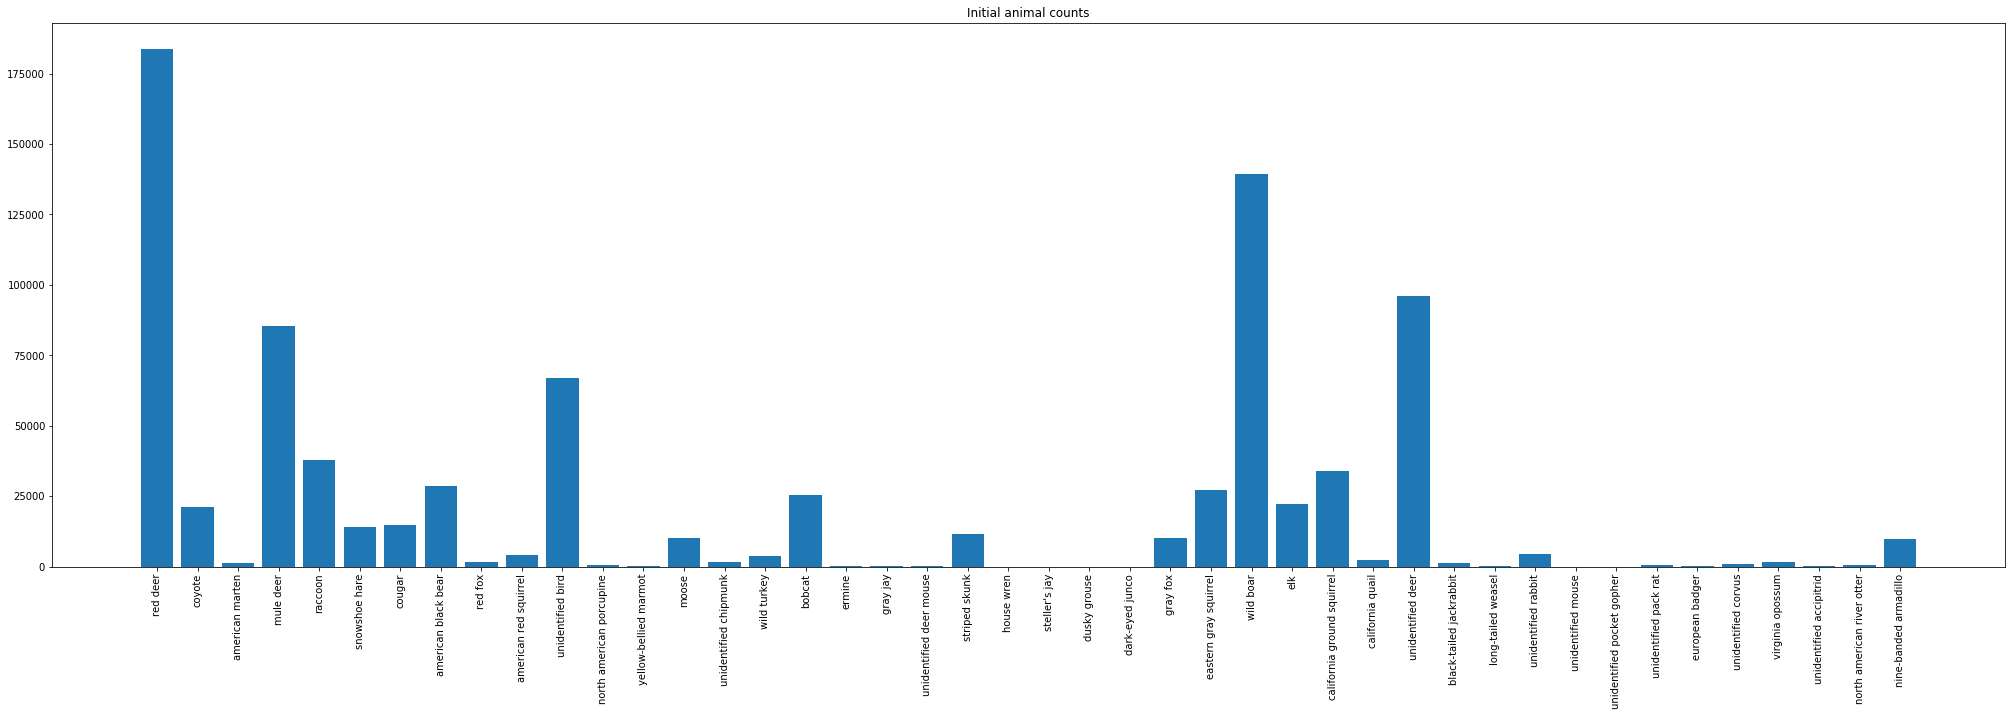

In [10]:
intitial_animal_counts = {}

for animal in df.common_name.unique():
    intitial_animal_counts[animal] = len(df[df['common_name'] == animal])

fig, ax = plt.subplots(figsize=(35,10))  

names = list(intitial_animal_counts.keys())
values = list(intitial_animal_counts.values())

plt.bar(range(len(intitial_animal_counts)), values, tick_label=names)
plt.xticks(rotation = 90)
plt.title('Initial animal counts')

# A-Priori Analysis

In [11]:
baskets = {}

for ct in camera_traps_set:
    baskets[ct] =  list(df[df['camera_traps'] == ct].common_name.unique())

In [12]:
animals = list(df.common_name.unique())

animal_counts = {}

#intialize animal counts dictionary
for animal in animals:
    animal_counts[animal] = 0

for basket in baskets.values():
    for animal in basket:
        animal_counts[animal] += 1

s = 0.03*len(baskets) 

#eliminate animals below support threshold
for animal in animals:
    if animal_counts[animal] < s:
        animal_counts.pop(animal)

In [13]:
#initialize lookup dictionary
frequent_animals = list(animal_counts.keys())
lookup = {}
for i in range(len(animal_counts)):
    lookup[frequent_animals[i]] = i

#make list of triples (code taken from nb09)
trips = []
for idx1 in range(len(frequent_animals)):
    for idx2 in range(idx1+1, len(frequent_animals)):
        trips.append((lookup[frequent_animals[idx1]], lookup[frequent_animals[idx2]], 0))

In [14]:
#code taken from nb09
for basket in baskets.values():
    frequent_items = list(set(basket)&set(frequent_animals))
    for idx1 in range(len(frequent_items)):
        for idx2 in range(idx1+1, len(frequent_items)):
            # get the index within the triples array
            new_idx1 = lookup[frequent_items[idx1]]
            new_idx2 = lookup[frequent_items[idx2]]
            if new_idx1 > new_idx2:
                new_idx1, new_idx2 = new_idx2, new_idx1
            k = int(new_idx1*(len(frequent_animals) - (new_idx1+1)/2) + new_idx2 - new_idx1 - 1)
            # update the counter in the triples array
            # tuples are immutable, so need full reassignment
            trips[k] = (new_idx1, new_idx2, trips[k][2]+1)

In [15]:
trip_candidates = []
for trip in trips:
    if trip[2] > s:
        trip_candidates.append(trip)

frequent_pairs = []
for trip in trip_candidates:
    pair = [frequent_animals[trip[0]], frequent_animals[trip[1]], trip[2]] #make array of pairs as well as their counts
    frequent_pairs.append(pair)

In [16]:
#count how many times each animal occurs with other animals
frequent_animal_net = {}

#intialize new animal counts dictionary
for animal in frequent_animals:
    frequent_animal_net[animal] = []

for pair in frequent_pairs:
    if pair[1] not in frequent_animal_net[pair[0]]:
        frequent_animal_net[pair[0]].append(pair[1])

    if pair[0] not in frequent_animal_net[pair[1]]:
        frequent_animal_net[pair[1]].append(pair[0])

In [17]:
keystone_mean_confidence = {}
keystone_support = {}

for animal in frequent_animals:
    if animal in keystone_species:
        animal_count = 0
        for basket in baskets.values():
            for a in basket:
                if a == animal:
                    animal_count += 1
            keystone_support[animal] = animal_count/len(baskets)

        confidence_sum = 0
        pair_count = 0
        for pair in frequent_pairs:
            if pair[0] == animal or pair[1] == animal:
                pair_count += 1
                confidence_sum += pair[2]/animal_count

        keystone_mean_confidence[animal] = confidence_sum/pair_count

print('Support of keystone animals:',keystone_support)
print('Average confidence of other keystone animals with other animals:',keystone_mean_confidence)

Support of keystone animals: {'coyote': 0.739344262295082, 'snowshoe hare': 0.580327868852459, 'cougar': 0.1557377049180328, 'american black bear': 0.4540983606557377, 'american red squirrel': 0.3360655737704918, 'bobcat': 0.2278688524590164, 'north american river otter': 0.03934426229508197}
Average confidence of other keystone animals with other animals: {'coyote': 0.2179830262252465, 'snowshoe hare': 0.43714689265536716, 'cougar': 0.45761772853185595, 'american black bear': 0.29061371841155226, 'american red squirrel': 0.5068736141906874, 'bobcat': 0.34615384615384615, 'north american river otter': 0.994047619047619}


In [18]:
print('number of frequent animals: ', len(frequent_animals))
print('number of frequent animal pairs: ', len(frequent_pairs))

number of frequent animals:  31
number of frequent animal pairs:  210


Text(0.5, 1.0, 'keystone species support ranking')

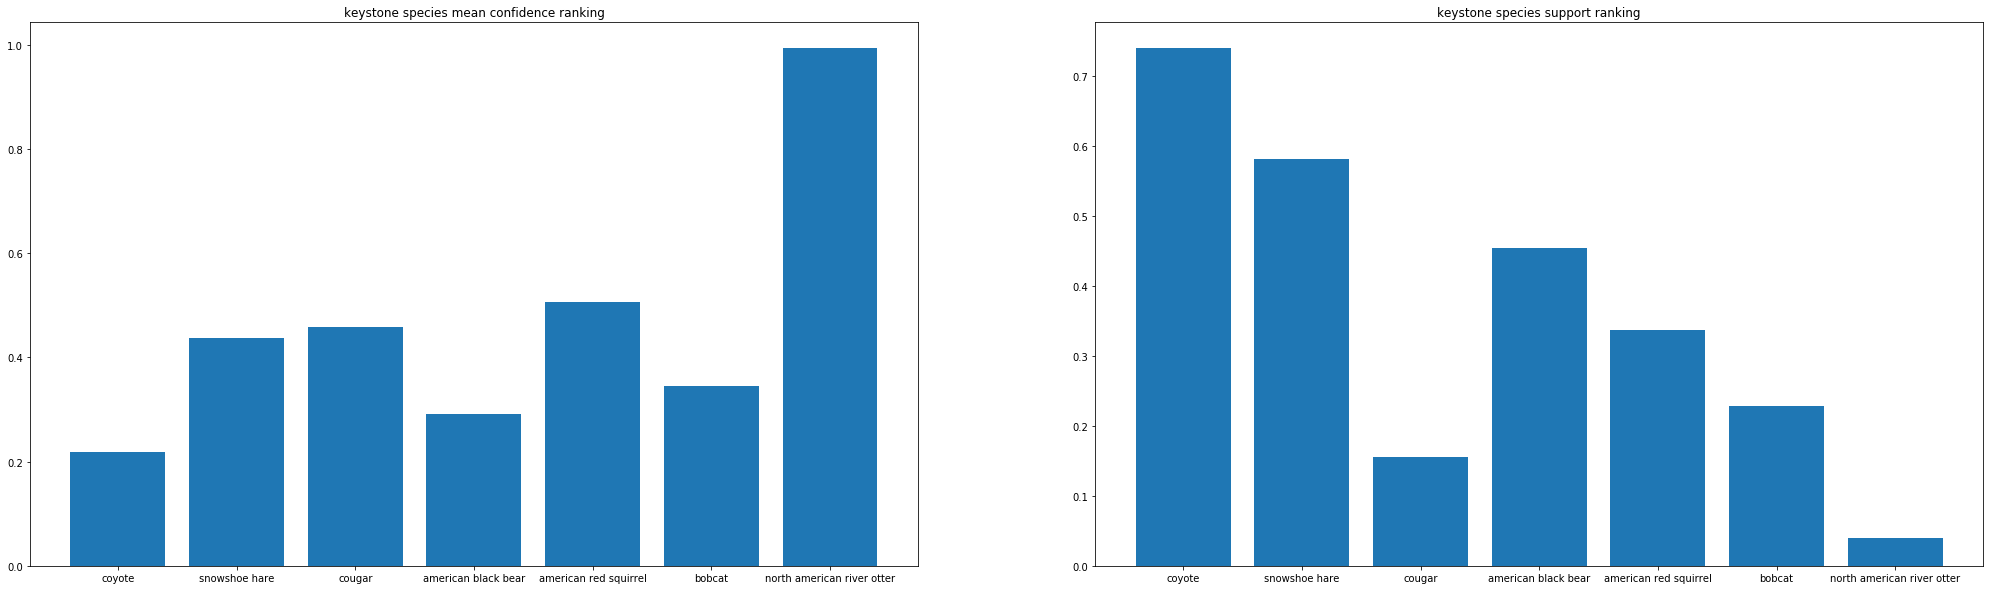

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(35,10),nrows=1,ncols=2)  

names = list(keystone_mean_confidence.keys())
values = list(keystone_mean_confidence.values())

ax[0].bar(range(len(keystone_mean_confidence)), values, tick_label=names)
ax[0].set_title('keystone species mean confidence ranking')

names = list(keystone_support.keys())
values = list(keystone_support.values())

ax[1].bar(range(len(keystone_support)), values, tick_label=names)
ax[1].set_title('keystone species support ranking')

# Undirected Graph Species Network

First, create network matrix

In [20]:
mat = np.zeros((len(frequent_animals),len(frequent_animals)))

for trip in trip_candidates:

    mat[trip[0]][trip[1]] = trip[2]
    mat[trip[1]][trip[0]] = trip[2]

check = 22
mat1=mat.copy()
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        if mat[i][j] < check:
            mat1[i][j] = 0
            mat1[j][i] = 0


print('Matrix sparsity:',len(np.where(mat1 == 0)[0])/(mat1.shape[0]*mat1.shape[1]))
A=np.zeros((len(mat1), len(mat1)))
A[mat1>0]=1
nofriends=np.where(np.sum(A, axis=0)==0)[0][0] 
A=np.delete(A,nofriends, axis=0)
A=np.delete(A,nofriends, axis=1)
names=np.array(frequent_animals)
names=np.delete(names,nofriends)

Matrix sparsity: 0.5858480749219563


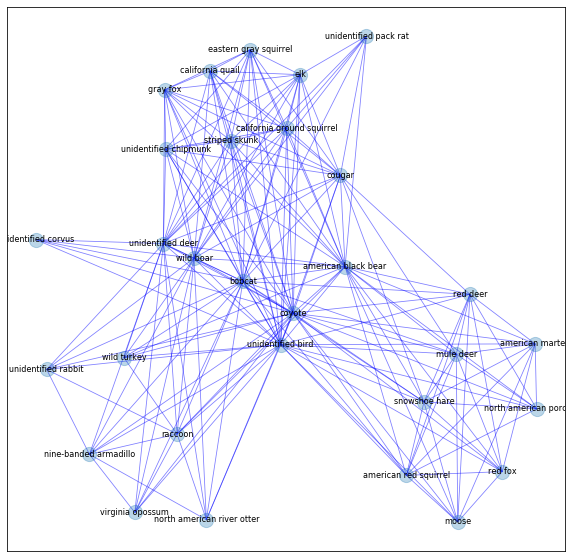

In [21]:
G=nx.Graph()
neighbors=dict.fromkeys(range(len(A)))

for i in range(len(A)):
    neighbors[i]=np.where(A[:,i])[0]
# neighbors

nodes=[i for i in range(len(A))]
G.add_nodes_from(nodes)
for i in range(len(A)):
    toadd=neighbors[i]
    for j in range(len(toadd)):
        G.add_edge(i,toadd[j])


fig, ax = plt.subplots(figsize=(10,10))      
np.random.seed(4022)
pos = nx.spring_layout(G) #algorithm that tries to "cluster" node plot locations; it saves the xy coords of each vertex
nx.draw_networkx_nodes(G, pos, node_size=200, alpha=.3); #node colors easy to see labels over
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.5, edge_color='blue'); #draw edges, using xy-node layout provided
labels=dict(zip(range(len(A)),names))
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black'); #label vertices by index/number

In [26]:
centers = list(sorted(keystone_mean_confidence.items(), key = lambda kv:(kv[1], kv[0]))[-3:][::-1])

center_A = frequent_animals.index(centers[0][0])
center_B = frequent_animals.index(centers[1][0])
center_C = frequent_animals.index(centers[2][0])

Text(0.5, 1.0, 'Initial centers')

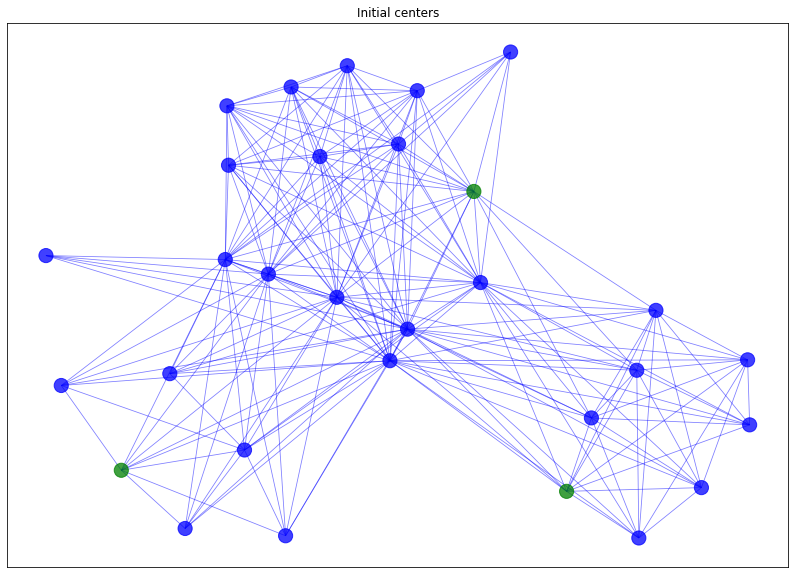

In [23]:
centers=set([center_A,center_B,center_C])
colorf=lambda x: 'green' if (x in centers) else 'blue'
colors=[colorf(node) for node in nodes]
#draw the nodes, using xy-node layout 'pos' provided
fig, ax = plt.subplots(figsize=(14,10))      
np.random.seed(4022)
pos = nx.spring_layout(G) #algorithm that tries to "cluster" node plot locations; it saves the xy coords of each vertex
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=200, alpha=.75); #node colors easy to see labels over
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.5, edge_color='blue'); #draw edges, using xy-node layout provided
# nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black'); #label vertices by index/number
ax.set_title('Initial centers')

# BigCLAM

In [24]:
import math

communities = [center_A,center_B,center_C]

F = np.zeros((len(nodes),4))

t = math.sqrt(np.log(0.99)*-1) #set background probability

#set background probability
for i in range(len(nodes)):
    F[i][3] = t

for i in range(len(communities)):
        F[communities[i]][i] = 1

#code adapted from nb15
comm_sums=F.sum(0) #sum over all communities, cached for updating in later version
nu = 10**-5 #step size

for lezgo in range(50000): #number of iterations
        for i in nodes: #loop over rows of F
                F_grad=np.zeros(4) #initialize gradient
                comm_sums=F.sum(0) #should be cached, will deal with later since it's annoying to update correctly with the 0-check
                for j in neighbors[i]: #loop over nbrs of that row's node
                        IP=np.exp(-np.inner(F[i], F[j])) #so we don't have to double compute
                        #print(len(F[j]))
                        F_grad+=F[j]*(1/(1-IP)) ##"first sum" above.
                #                 print(i,j,F_grad)
                step=nu*(F_grad-comm_sums) #including F[i] here is the difference between you-are-own-neighbor and not
                #         step=eta*(F_grad-comm_sums-F[i]) #correct option; above DIVERGES as steps->infty
                #print(step)
                F[i][:3]+=step[:3] #update row; do as two steps so can use "step" to update comm_sums later
                F[i,F[i,:]<0]=0 #0-check
                #         print('i',i,'step:', F_grad, 'baseline:',comm_sums) # sanity checks


Text(0.5, 1.0, 'Community 3, initialized with cougar')

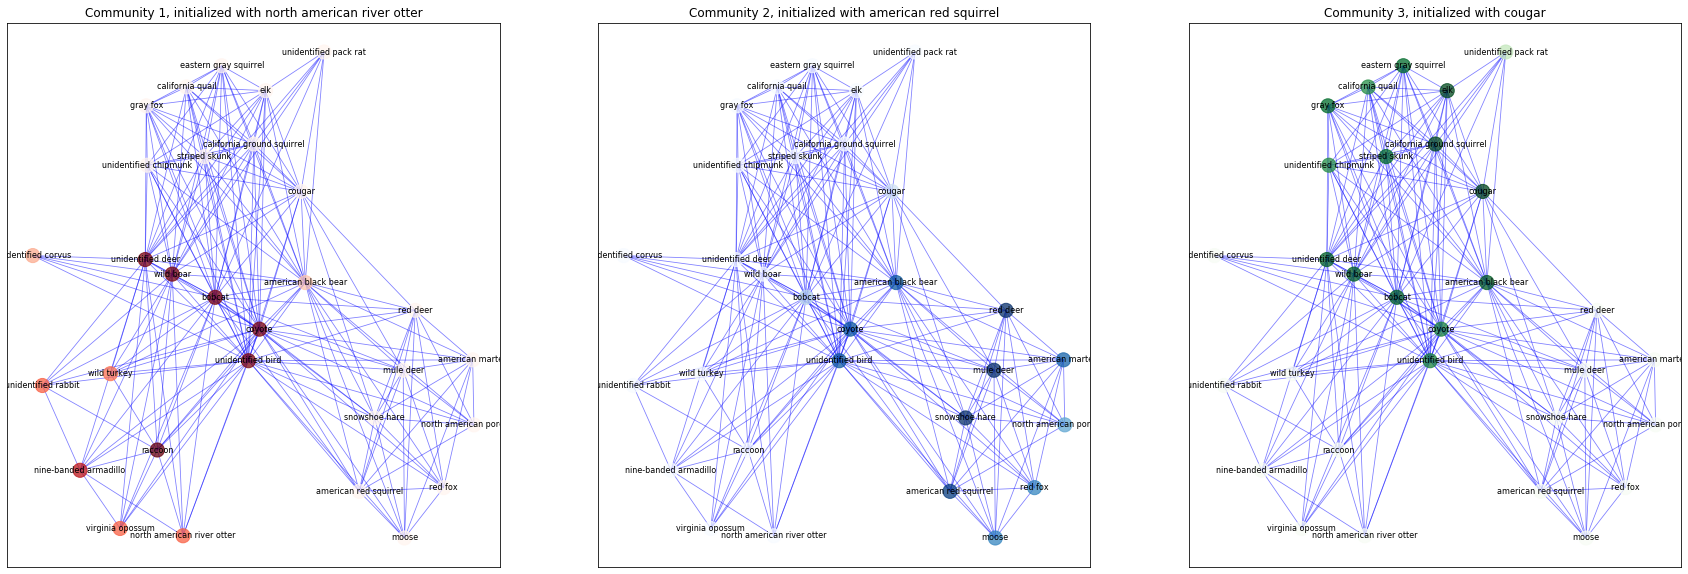

In [27]:
#strengths of affiliation
c1 = F.T[0]
c2 = F.T[1]
c3 = F.T[2]

#draw the nodes, using xy-node layout 'pos' provided
fig, ax = plt.subplots(figsize=(30,10),nrows=1,ncols=3)   

fig.set_facecolor('white')

np.random.seed(4022)
pos = nx.spring_layout(G) #algorithm that tries to "cluster" node plot locations; it saves the xy coords of each vertex

#nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black')

nx.draw_networkx_nodes(G, pos, node_color=c1, node_size=200, alpha=.75, cmap=plt.cm.Reds, ax=ax[0]); #node colors easy to see labels over
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.5, edge_color='blue', ax=ax[0]); #draw edges, using xy-node layout provided
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black', ax=ax[0])



nx.draw_networkx_nodes(G, pos, node_color=c2, node_size=200, alpha=.75, cmap=plt.cm.Blues, ax=ax[1]); #node colors easy to see labels over
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.5, edge_color='blue', ax=ax[1]); #draw edges, using xy-node layout provided
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black', ax=ax[1])



nx.draw_networkx_nodes(G, pos, node_color=c3, node_size=200, alpha=.75, cmap=plt.cm.Greens, ax=ax[2]); #node colors easy to see labels over
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.5, edge_color='blue', ax=ax[2]); #draw edges, using xy-node layout provided
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black', ax=ax[2])



ax[0].set_title(str('Community 1, initialized with '+centers[0][0]))
ax[1].set_title(str('Community 2, initialized with '+centers[1][0]))
ax[2].set_title(str('Community 3, initialized with '+centers[2][0]))

In [ ]:
c1_affiliation_dict = {}
c2_affiliation_dict = {}
c3_affiliation_dict = {}

for i in range(len(c1)):
    c1_affiliation_dict[names[i]] = c1[i]
    c2_affiliation_dict[names[i]] = c2[i]
    c3_affiliation_dict[names[i]] = c3[i]

#print(c1_affiliation_dict)

#dictionary ranking method source: https://www.geeksforgeeks.org/python-sort-python-dictionaries-by-key-or-value/
print('Top 7 species affiliated with community 1:', sorted(c1_affiliation_dict.items(), key = lambda kv:(kv[1], kv[0]))[-7:][::-1]) 
print()
print('Top 7 species affiliated with community 2:', sorted(c2_affiliation_dict.items(), key = lambda kv:(kv[1], kv[0]))[-7:][::-1]) 
print()
print('Top 7 species affiliated with community 3:', sorted(c3_affiliation_dict.items(), key = lambda kv:(kv[1], kv[0]))[-7:][::-1]) 

Top 7 species affiliated with community 1: [('raccoon', 1.607175578448416), ('wild boar', 1.5490838797121114), ('unidentified deer', 1.549081743016456), ('bobcat', 1.5345036392864586), ('coyote', 1.5329041525074125), ('unidentified bird', 1.5329035036252492), ('nine-banded armadillo', 1.2827744973722277)]

Top 7 species affiliated with community 2: [('snowshoe hare', 1.7149012267512667), ('red deer', 1.714901210428736), ('mule deer', 1.7149011092906425), ('american red squirrel', 1.6151971724441205), ('american black bear', 1.4452023953883364), ('unidentified bird', 1.4427363879254334), ('coyote', 1.44273341659399)]

Top 7 species affiliated with community 3: [('cougar', 1.7160906719758044), ('elk', 1.6863960323254363), ('california ground squirrel', 1.6863959556179993), ('american black bear', 1.6007482698477564), ('unidentified deer', 1.5713337977535402), ('wild boar', 1.5713321141612595), ('bobcat', 1.5689524561804353)]


# Jaccard Similarity of top 8 species in each community with predetermined keystone species

In [ ]:
def jaccard_similarity(keystones,model_top_8):
    animals = list(set(keystones+model_top_8))

    sims = np.zeros((len(animals),2))

    for i in range(len(animals)):
        if animals[i] in keystones:
            sims[i][0] = 1
        if animals[i] in model_top_8:
            sims[i][1] = 1
    
    numer = 0
    denom = 0
    for i in range(len(sims)):
        if sims[i][0] == 1 and sims[i][1] == 1:
            numer += 1
        if sims[i][0] == 1 or sims[i][1] == 1:
            denom += 1

    return numer/denom

In [ ]:
c1_mc_top_8 = list(np.array(sorted(c1_affiliation_dict.items(), key = lambda kv:(kv[1], kv[0]))[-7:][::-1])[:,0])
c2_mc_top_8 = list(np.array(sorted(c2_affiliation_dict.items(), key = lambda kv:(kv[1], kv[0]))[-7:][::-1])[:,0])
c3_mc_top_8 = list(np.array(sorted(c3_affiliation_dict.items(), key = lambda kv:(kv[1], kv[0]))[-7:][::-1])[:,0])

coms_top_8 = [c1_mc_top_8,c2_mc_top_8,c3_mc_top_8]

jcs = []
for com in coms_top_8:
    jcs.append(jaccard_similarity(keystone_species,com))

print('Jaccard similarity of top 8 species of community 1 with keystone species:',jcs[0])
print('Jaccard similarity of top 8 species of community 2 with keystone species:',jcs[1])
print('Jaccard similarity of top 8 species of community 3 with keystone species:',jcs[2])

Jaccard similarity of top 8 species of community 1 with keystone species: 0.16666666666666666
Jaccard similarity of top 8 species of community 2 with keystone species: 0.4
Jaccard similarity of top 8 species of community 3 with keystone species: 0.2727272727272727
